In [15]:
import codecs
import glob
import multiprocessing
import os
import pprint
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt

In [16]:
stopwords = stopwords.words('english')
print stopwords

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're", u"you've", u"you'll", u"you'd", u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u"she's", u'her', u'hers', u'herself', u'it', u"it's", u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u"that'll", u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'eac

# Pre-processing of Data Structure Book

In [17]:
def pre_process_books(input_file, output_file):
    

    file_read = codecs.open(input_file, 'rb', encoding='utf8', errors="ignore")
    file_write = codecs.open(output_file, 'w', encoding='utf8', errors="ignore") #save file after cleaning
    reg1 = r"(#)(\d)"
    reg = r"[a-z][A-Z]"
    for line in file_read.readlines():
        line = line.strip()

        if line == 'i':
            continue

        if len(line) == 0:
            continue
        if line[-1] == ';':
            continue
        #Ignore text in the bibliography
        if line == 'Bibliography':
            break
        # Ignore appendix
        if line == 'Appendix A':
            break

        # ignore page numbers
        pages = re.findall(reg1, line)
        if len(pages) > 0:
            continue

        #lines containing only //
        if line[0:2] == '//':
    #         print line
            continue
        if line == '.' or line == '-' or line == '. .' or line == '...':
    #         print line
            continue

        if line == 'This page intentionally left blank':
            continue

        #search lines with (a), (b) so on. to remote unnecessary alphabets
        # It also removes few lines with equations
        m = re.search(r"\(([a-z]+)\)", line[0:3])
        if m is not None:
            continue
            
        #remove unneccasry single characters from line
        if len(line) < 3:
            continue

        if line[0] in ['1','2','3','4','5','6','7','8','9']:
            if len(line) < 5:
                continue

        file_write.write(line + '\n')
    file_write.close()

    file_read.close()

In [18]:
#1st book
# input_file = './data_structure_books/data-structures-and-algorithms-in-c++.txt'
# output_file = './data_structure_books/data-structures-and-algorithms-in-c++-cleaned_recent.txt'

#2nd book
# input_file = './data_structure_books/DataStructuresAndAlgorithmAnalysisInCpp_2014.txt'
# output_file = './data_structure_books/DataStructuresAndAlgorithmAnalysisInCpp_2014_cleaned.txt'

#3rd book
input_file = './data_structure_books/Esam Halim Houssein Abd El-Halim_4- Data-Structure Using C++ Malik.txt'
output_file = './data_structure_books/cleaned_books/Data-Structure Using C++ Malik_cleaned.txt'
pre_process_books(input_file, output_file)

# Word Embeddings

In [21]:
def prepare_corpus():
    
    # Combine books in one string
    corpus_raw = u""
    book_filenames = sorted(glob.glob('./data_structure_books/cleaned_books/*.txt'))
    for book_filename in book_filenames:
        print("Reading '{0}'...".format(book_filename))
        with codecs.open(book_filename, "r", encoding="utf8") as book_file:
            corpus_raw += book_file.read()
        print("Corpus is now {0} characters long".format(len(corpus_raw)))
        print ""
    tokenized_sentences = sent_tokenize(corpus_raw)
    return tokenized_sentences


In [22]:
input_book = './data_structure_books/cleaned_books/'
tokenized_sentences = prepare_corpus()

Reading './data_structure_books/cleaned_books/Data-Structure Using C++ Malik_cleaned.txt'...
Corpus is now 1186592 characters long

Reading './data_structure_books/cleaned_books/DataStructuresAndAlgorithmAnalysisInCpp_2014_cleaned.txt'...
Corpus is now 2354863 characters long

Reading './data_structure_books/cleaned_books/data-structures-and-algorithms-in-c++-cleaned_recent.txt'...
Corpus is now 3658299 characters long



In [23]:
#convert into a list of words
#remove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    filtered_words = []
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    for word in words:
        utf8string = word.encode("utf-8")
        #convert to lowercase, but stop words are not properly filtered
        utf8string = utf8string.lower()
        if utf8string not in stopwords:
            filtered_words.append(word)
        
    return filtered_words

#sentence where each word is tokenized
sentences = []
count = 0
for raw_sentence in tokenized_sentences:
    if len(raw_sentence) > 0:
#         count = count + 1
        sentences.append(sentence_to_wordlist(raw_sentence))
#         if count > 1:
#             break
        
print(tokenized_sentences[5])
print(sentence_to_wordlist(tokenized_sentences[5]))

Instead, they use word processing software to complete their term papers.
[u'Instead', u'use', u'word', u'processing', u'software', u'complete', u'term', u'papers']


In [24]:
#count total number of sentences
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 347,130 tokens


In [25]:
# Train word2Vec

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 15

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

# Create and Train word2vec Model

In [26]:
# if sg = 1 then CBOW is used else skip-gram model
DataStruct2vec = w2v.Word2Vec(sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

### Save word2vec model

In [27]:
# harryPorter2vec.build_vocab(sentences)
model_name = "DataStructureModel"
DataStruct2vec.save(model_name)

# load saved model

In [28]:
new_model = w2v.Word2Vec.load('DataStructureModel')

In [29]:
#list vocabulary
vocab = list(new_model.wv.vocab.keys())
print vocab[:160]

[u'limited', u'dynamic', u'myClock', u'four', u'prefix', u'consists', u'grandparent', u'saved', u'consider', u'relationships', u'whose', u'votes', u'const', u'violate', u'Overloading', u'swap', u'summarizes', u'digit', u'void', u'Elem', u'handling', u'rFibNum', u'updates', u'affect', u'encounter', u'Gr', u'progression', u'MAX', u'solution', u'objectOne', u'SLinkedList', u'vector', u'phase', u'indices', u'heading', u'force', u'speci', u'Fortunately', u'consistent', u'bubbling', u'direct', u'likely', u'implemented', u'blue', u'errors', u'Initially', u'ned', u'selected', u'causes', u'reconstruction', u'designing', u'new', u'increasing', u'ever', u'consisting', u'Deletes', u'coefficient', u'never', u'residual', u'classIllusFriend', u'cult', u'path', u'logarithmic', u'calculate', u'obtained', u'balance', u'tapes', u'items', u'study', u'changed', u'credit', u'changes', u'prints', u'divide', u'arrayListType', u'replace', u'Also', u'Basic', u'DLinkedList', u'total', u'unit', u'would', u'remain

In [36]:
new_model.wv.most_similar('Inheritance', topn=10)

[(u'Polymorphism', 0.8963212966918945),
 (u'hierarchy', 0.8903619050979614),
 (u'declarations', 0.8605943918228149),
 (u'inheritance', 0.8516863584518433),
 (u'shape', 0.8455238938331604),
 (u'Progression', 0.8447824120521545),
 (u'dateType', 0.833106279373169),
 (u'derived', 0.8303465247154236),
 (u'Classes', 0.82403963804245),
 (u'classIllusFriend', 0.8233147263526917)]

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


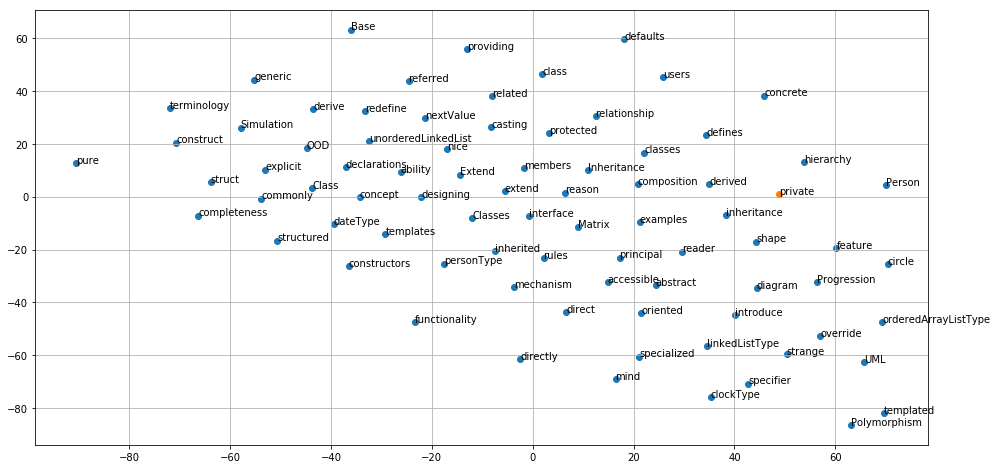

In [34]:
def TSNEPlot(model, word, dimension):
    
    #Empty vector, to append embeddings of closer/similar words
    embeddings_vector = np.empty((0,dimension), dtype='f')
#     word = word.lower()
    related_words = []
    related_words.append(word)
    queried_word_vector = (model[word])
    queried_word_vector = queried_word_vector.reshape(1,300)
    get_similar_words = model.wv.most_similar(word, topn=80)
    embeddings_vector = np.append(embeddings_vector, queried_word_vector, axis=0)
    
    for sim_word in get_similar_words:
        word = sim_word[0]
        word_vector = model[word]
        related_words.append(word)
        word_vector = word_vector.reshape(1,300)
        embeddings_vector = np.append(embeddings_vector, word_vector, axis=0)
    
    # Reduce 300 dimension into two dimension and do scatter plotting
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
    Y = tsne.fit_transform(embeddings_vector)
    plt.figure(figsize=(16,8))
    x_coords = Y[1:, 0]
    y_coords = Y[1:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(related_words, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.scatter([Y[0, 0]], [Y[0,1]])
    plt.annotate(word, xy=(Y[0,0], Y[0,1]), xytext=(0, 0), textcoords='offset points')
    plt.grid(True)
    plt.show()
    
new_model = w2v.Word2Vec.load('DataStructureModel')
TSNEPlot(new_model, 'inheritance', dimension = 300)